# Introduction

In this notebook we will explore the accidents data to predict if a police officer will attend a road accident. The notebook is structured as follows:
1. Read data, and join to lookups (I found online) that will decipher some of the numeric columns. For example, the Did_Police_Officer_Attend_Scene_of_Accident contains 1s and 2s. The lookup will tell us if this means yes or no
2. Explore the target. We find that Police attend ~80% of accidents
3. Feature engineering. Here we create new variables such as time based, binning numeric variables, and getting substrings of location IDs 
4. Plot targets using longitude and latitude. This allows us to see whether police officers attend accidents near each other, then map locations to see if they match clusters of accidents with the target
5. Define functions for target_rate and counts, that allow us to plot both on a bar chart. This helps us to see categories with high volumes and high target rates
6. Plot target rate and volumes for numeric variables like number of vehicles and casualties, so we can bin numeric variables
7. Analyse low cardinality variables, to find good options for features i.e. high/low target rate with high volumes. We pick low cardinality as it will be easier to plot and bin
8. Binning categorical variables into bins with high or low target rates
9. Analysing time data to see if police officers attend more at certain times of the day/week/year
10. Group the data into NUTS3 UK regions, to see if we can create larger regions, and isolate areas with high target rates. This makes use of the geopandas package
11. Remove highly correlated variables, and save the final variables in a dictionary to use later for modelling


The data source seems to be from here, which is where I got the lookups
https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data/datafile/36f1658e-b709-47e7-9f56-cca7aefeb8fe/preview


## Import Packages

In [362]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import numpy as np

# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

import data_prep as dp

In [363]:
pd.set_option('display.max_columns', 500)

Package versions

In [468]:
# import matplotlib
# import shapely

# print('pandas=='+pd.__version__)
# print('seaborn=='+sns.__version__)
# print('matplotlib=='+matplotlib.__version__)
# print('numpy=='+np.__version__)
# print('geopandas=='+gpd.__version__)
# print('shapely=='+shapely.__version__)

## Read data

In [364]:
df = pd.read_csv('train_data.csv',parse_dates=['Date'])
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201301BS70003,527060,177970,-0.171402,51.486361,1,2,2,1,2013-02-01,4,09:08,12,E09000020,3,3217,6,30,3,4,6,0,0,0,1,1,1,0,0,1,1,E01002844
1,201301BS70005,526900,178940,-0.173356,51.495115,1,3,1,2,2013-04-01,6,08:16,12,E09000020,3,3218,6,30,6,2,3,3218,0,5,1,8,1,0,0,1,1,E01002821
2,201301BS70006,524240,181460,-0.210767,51.518353,1,3,1,1,2013-07-01,2,11:45,12,E09000020,4,450,6,30,6,4,4,412,0,1,1,1,1,0,0,1,1,E01002878
3,201301BS70007,524320,181290,-0.209675,51.516808,1,3,2,1,2013-10-01,5,10:40,12,E09000020,4,450,6,30,6,2,5,0,0,5,1,1,1,0,0,1,1,E01002831
4,201301BS70009,525450,178660,-0.194332,51.492922,1,3,2,1,2013-04-01,6,17:47,12,E09000020,3,3220,2,30,3,4,6,0,0,0,4,1,1,0,0,1,1,E01002851


## Join lookup
I obtained a lookup for some of the columns from this website https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data  
This will help give more context on columns which are integers. Manipulated columns will be printed

In [366]:
df.rename(columns={'Weather_Conditions':'Weather','Urban_or_Rural_Area':'Urban_Rural','Did_Police_Officer_Attend_Scene_of_Accident':'Police_Officer_Attend','Road_Surface_Conditions':'Road_Surface'},inplace=True)

all_dfs_dict = pd.read_excel('variable lookup.xls',sheet_name=None)

In [367]:
for col in df.columns:
    
    cleaned_keys = [ i.replace(' ','_') for i in all_dfs_dict.keys()]
#     print(col)
    if col in cleaned_keys:
        print(col)
        old_col = col.replace('_',' ')
        lookup_df = all_dfs_dict[old_col].copy()
        lookup_df.columns = [i.lower() for i in lookup_df.columns]
        lookup_df['code'] = lookup_df['code'].astype(object)
        
        df[col] = df[col].astype(object)
        
        print(df.shape)
        lookup_df.rename(columns={'code':col,'label':col+'_Name'},inplace=True)

        df = df.merge(lookup_df,how='left').copy()
        df.drop(col,inplace=True,axis=1)

        df.rename(columns={col+'_Name':col},inplace=True)
        
        

Police_Force
(138660, 32)
Accident_Severity
(138660, 32)
Day_of_Week
(138660, 32)
Local_Authority_(District)
(138660, 32)
Local_Authority_(Highway)
(138660, 32)
1st_Road_Class
(138660, 32)
Road_Type
(138660, 32)
Junction_Detail
(138660, 32)
Junction_Control
(138660, 32)
2nd_Road_Class
(138660, 32)
Light_Conditions
(138660, 32)
Weather
(138660, 32)
Road_Surface
(138660, 32)
Special_Conditions_at_Site
(138660, 32)
Carriageway_Hazards
(138660, 32)
Urban_Rural
(138660, 32)
Police_Officer_Attend
(138660, 32)


In [368]:
df['Police_Officer_Attend'].value_counts()

Yes    113358
No      25301
Name: Police_Officer_Attend, dtype: int64

# Check for nulls
There are nulls in time and lsoa_of_accident

In [369]:
# df.isnull().sum()

## Check for data types
Date can be transformed to data format,
values that aren't floats can be transformed

In [370]:
# df.dtypes

In [371]:
# df.nunique()

## Apply data prep
We will make all columns lower case and rename the police officer attend column to target

In [372]:
df.columns = [i.lower() for i in df.columns]

df.rename(columns={'police_officer_attend':'target'},inplace=True)

In [373]:
df.head()

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,date,time,1st_road_number,speed_limit,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,lsoa_of_accident_location,police_force,accident_severity,day_of_week,local_authority_(district),local_authority_(highway),1st_road_class,road_type,junction_detail,junction_control,2nd_road_class,light_conditions,weather,road_surface,special_conditions_at_site,carriageway_hazards,urban_rural,target
0,201301BS70003,527060,177970,-0.171402,51.486361,2,1,2013-02-01,09:08,3217,30,0,0,0,E01002844,Metropolitan Police,Serious,Wednesday,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,T or staggered junction,Give way or uncontrolled,Unclassified,Daylight,Fine no high winds,Dry,None,None,Urban,Yes
1,201301BS70005,526900,178940,-0.173356,51.495115,1,2,2013-04-01,08:16,3218,30,3218,0,5,E01002821,Metropolitan Police,Slight,Friday,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,Crossroads,Auto traffic signal,A,Daylight,Other,Dry,None,None,Urban,Yes
2,201301BS70006,524240,181460,-0.210767,51.518353,1,1,2013-07-01,11:45,450,30,412,0,1,E01002878,Metropolitan Police,Slight,Monday,Kensington and Chelsea,Kensington and Chelsea,B,Single carriageway,Crossroads,Give way or uncontrolled,B,Daylight,Fine no high winds,Dry,None,None,Urban,Yes
3,201301BS70007,524320,181290,-0.209675,51.516808,2,1,2013-10-01,10:40,450,30,0,0,5,E01002831,Metropolitan Police,Slight,Thursday,Kensington and Chelsea,Kensington and Chelsea,B,Single carriageway,Crossroads,Auto traffic signal,C,Daylight,Fine no high winds,Dry,None,None,Urban,Yes
4,201301BS70009,525450,178660,-0.194332,51.492922,2,1,2013-04-01,17:47,3220,30,0,0,0,E01002851,Metropolitan Police,Slight,Friday,Kensington and Chelsea,Kensington and Chelsea,A,One way street,T or staggered junction,Give way or uncontrolled,Unclassified,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes


# Explore the target
82% of accidents are attended by police officers

In [374]:
df['target'].value_counts(normalize=True)

Yes    0.817531
No     0.182469
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='count'>

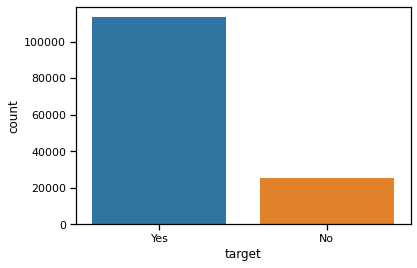

In [375]:
sns.countplot(df['target'])

Create a binary column for target

In [376]:
df['target'] = np.where(df['target']=='Yes',1,0)

# Feature engineering

## Time variables
We will extract hour and minute from the time column and split days into weekday/weekend.  
Variable 15 mins past hour is analysed later to show it has low target rate

In [377]:
# Time
df['hour'] = df['time'].str[:2]
df['minutes_past_hour'] = df['time'].str[-2:]
df['month'] = df.date.dt.month
df['15_mins_past_hour'] = np.where(df['minutes_past_hour'].isin(['00','15','30','45']),1,0)
df['weekday']= np.where(((df['day_of_week']!='Saturday' ) &(df['day_of_week']!='Sunday')),1,0)

df['night_time'] = df['hour'].isin(['23','00', '01', '02', '03', '04', '05', '06'],1,0)

We will create lists for excluding variables and including variables later. The used_time_variables go into the final modelling dataset

In [379]:
time_variables = ['night_time','hour','minutes_past_hour','day_of_week','month','15_mins_past_hour','weekday','time','date']

In [380]:
used_time_variables = ['night_time','15_mins_past_hour','weekday']

## Numeric variables
Analysis later show this bins have higher target rate

In [381]:
# generate binned variables for numeric columns
df['number_of_casualties_more_than_2'] = np.where(df['number_of_casualties']>2,1,0)
df['number_of_vehicles_more_than_2'] = np.where(df['number_of_vehicles']>2,1,0)

In [382]:
numeric_variables = ['number_of_casualties','number_of_casualties_more_than_2','number_of_vehicles','number_of_vehicles_more_than_2']

In [383]:
used_numeric_variables = ['number_of_casualties_more_than_2','number_of_vehicles_more_than_2']

## Location based variables
As a lot of location based data are code format, it might be useful to extract substrings from the codes if they represent less granular areas. Here we define a function for the extraction and define new columns  
Previously I did not have lookups for the local authority district and highway, and was extracting the E, S, W (england,scotland wales) from the variables for example, but now with lookup it's no longer needed. If I repeated this task I would probably keep the original variables too for analysis

In [384]:
def generate_substrings(data,col,n):
    '''
    This function generates new columns that are substrings of col. It will create n new columns. if n=3, the first column with suffix str1, will be a column with just the first character. Second will have two characters, and so on
    
    Parameters:
    data: pd.DataFrame. Data frame to manipulate
    col: col to create substrings of
    n: number of new cols to create
    '''
    new_cols = []
    for i in range(n):
        new_col_name = col+'_str'+str(i+1)
        data[new_col_name] = data[col].astype(str).str[:i+1]
        new_cols.append(new_col_name)       
            
    return new_cols

In [385]:
location_cols = []

# substring_col_mapping = {'local_authority_(highway)':3,'location_easting_osgr':1, 'location_northing_osgr':1,'local_authority_(district)':1}

substring_col_mapping = {'location_easting_osgr':1, 'location_northing_osgr':1}

for key, value in substring_col_mapping.items():
    location_cols = location_cols + generate_substrings(df,key,value)

In [386]:
location_cols

['location_easting_osgr_str1', 'location_northing_osgr_str1']

In [387]:
# for i in location_cols:
#     print(df[i].value_counts().head())
#     print(df[i].value_counts().shape)

In [388]:
df.head()

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,date,time,1st_road_number,speed_limit,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,lsoa_of_accident_location,police_force,accident_severity,day_of_week,local_authority_(district),local_authority_(highway),1st_road_class,road_type,junction_detail,junction_control,2nd_road_class,light_conditions,weather,road_surface,special_conditions_at_site,carriageway_hazards,urban_rural,target,hour,minutes_past_hour,month,15_mins_past_hour,weekday,night_time,number_of_casualties_more_than_2,number_of_vehicles_more_than_2,location_easting_osgr_str1,location_northing_osgr_str1
0,201301BS70003,527060,177970,-0.171402,51.486361,2,1,2013-02-01,09:08,3217,30,0,0,0,E01002844,Metropolitan Police,Serious,Wednesday,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,T or staggered junction,Give way or uncontrolled,Unclassified,Daylight,Fine no high winds,Dry,None,None,Urban,1,09,08,2,0,1,False,0,0,5,1
1,201301BS70005,526900,178940,-0.173356,51.495115,1,2,2013-04-01,08:16,3218,30,3218,0,5,E01002821,Metropolitan Police,Slight,Friday,Kensington and Chelsea,Kensington and Chelsea,A,Single carriageway,Crossroads,Auto traffic signal,A,Daylight,Other,Dry,None,None,Urban,1,08,16,4,0,1,False,0,0,5,1
2,201301BS70006,524240,181460,-0.210767,51.518353,1,1,2013-07-01,11:45,450,30,412,0,1,E01002878,Metropolitan Police,Slight,Monday,Kensington and Chelsea,Kensington and Chelsea,B,Single carriageway,Crossroads,Give way or uncontrolled,B,Daylight,Fine no high winds,Dry,None,None,Urban,1,11,45,7,1,1,False,0,0,5,1
3,201301BS70007,524320,181290,-0.209675,51.516808,2,1,2013-10-01,10:40,450,30,0,0,5,E01002831,Metropolitan Police,Slight,Thursday,Kensington and Chelsea,Kensington and Chelsea,B,Single carriageway,Crossroads,Auto traffic signal,C,Daylight,Fine no high winds,Dry,None,None,Urban,1,10,40,10,0,1,False,0,0,5,1
4,201301BS70009,525450,178660,-0.194332,51.492922,2,1,2013-04-01,17:47,3220,30,0,0,0,E01002851,Metropolitan Police,Slight,Friday,Kensington and Chelsea,Kensington and Chelsea,A,One way street,T or staggered junction,Give way or uncontrolled,Unclassified,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,1,17,47,4,0,1,False,0,0,5,1


# Plot locations on a map
This may show that targets occur near each other. The map shows the data is for the UK excluding NI

No handles with labels found to put in legend.


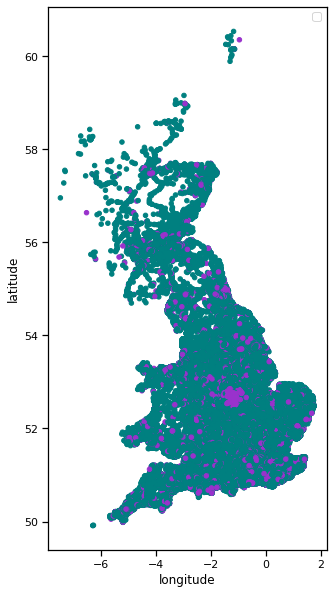

In [389]:
col = df.target.map({1:'teal', 0:'darkorchid'})
ax = df.plot(x='longitude',y='latitude',kind='scatter',figsize=(5,10),c=col)
ax.legend()

It might be possible to find location variables that are clutered around the target. Here we find that the northing_osgr and easting_osgr are likened to longitude and latitude, and will unlikely match clusters of targets. It is also difficult to see if urban/rurals better match with targets, but we will explore this variable more later on. However, the map supports the validity of the lookup, with urban areas located in london/cardiff/manchester etc

In [390]:
def plot_locations(col,ax_n):
    df_sub = df.sample(frac=0.3)
    sns.scatterplot(data=df_sub,x='longitude',y='latitude',hue=df_sub[col].to_list(),ax=ax_n)
    ax_n.set_title(col)
    

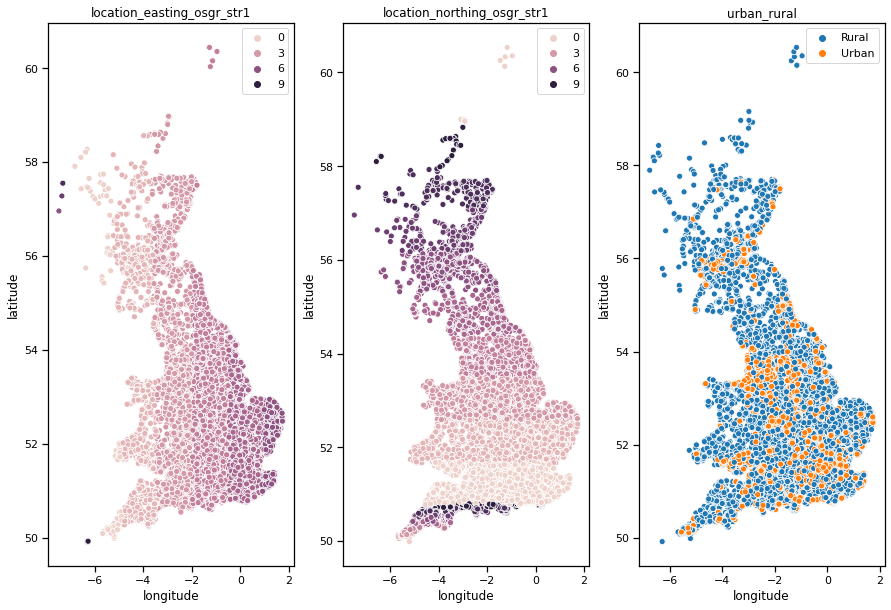

In [391]:
fig, ax  = plt.subplots(1,3,figsize=(15,10))

for col, ax_n in zip(location_cols+['urban_rural'],ax.flatten()):
    plot_locations(col,ax_n)

## Plot Target distribution for low cardinality features
We will try to find if particular values of a feature have a higher target rate, as well as volumes. This would make them good predictors. We can also bin features with similar target rates to increase volume against the feature and speed up training


In [392]:
## we will isolate variables which have low cardinality so we can plot them
cardinality = df.nunique()
low_cardinality = cardinality[cardinality<100]

low_cardinality = low_cardinality[low_cardinality.index != 'target']

len(low_cardinality)

29

It is difficult to determine the target rates from the volume for positive and negative target, so we will plot target rates with counts in the next plot

In [393]:
# sns.set_context('talk')
# fig, ax = plt.subplots(8,4,figsize=(50,40))
# for col,ax in zip(low_cardinality.index,ax.flatten()):
#     sns.countplot(df[col],hue=df['target'],ax=ax, order = df[col].value_counts().index[:20])
#     ax.set_title(col)
#     plt.tight_layout()

## Define functions to plot target rate and count in one chart
get_target_rate_and_count will group the data, getting target rate, count, and count share  
plot_target_rate_and_count will plot the data  
target_rate_and_plot will combine both to plot one figure

In [394]:
def get_target_rate_and_count(data,col):
    '''
    Group your data set, and get the target rate and count for each group. The target column should be labelled 'target'
    
    Parameters:
    data: pandas.DataFrame
    col: string. Column to group by
    '''
    output = data.groupby([col]).agg({'target':'mean',col:'count'}).rename(columns={'target':'target_rate',col:'count'}).sort_values('target_rate',ascending=False)
    output['share'] = output['count']/sum(output['count'])
    return output    

In [395]:
def plot_target_rate_and_count(data,ax_n):
    '''
    Plot the target rate and count of your grouped data as a bar chart
    Parameters:
    data: pandas.DataFrame, data grouped by one column with target rate and count as metrics 
    ax_n: matplotlib.axes._subplots.AxesSubplot, matplotlib axes to plot chart on
    
    '''
    ax = data[['target_rate','count']].plot(kind='bar',secondary_y='count',ax=ax_n)
    ax.set_xlabel(data.index.name)
    ax.tick_params(axis='y', colors='tab:blue')
    ax.right_ax.tick_params(axis='y', colors='tab:orange')
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    
    

In [396]:
def target_rate_and_plot(col):
    '''
    note that this relies on there being a global variable df which is train dataset
    '''
    
    grouped = get_target_rate_and_count(df,col)
    fig,ax = plt.subplots(1,1,figsize=(30,5))
    grouped = grouped.sort_values(col)
    plot_target_rate_and_count(grouped,ax)
    ax
    return grouped

## Analyse numeric variables
Number of casualties and vehicles should be classed as numeric, and should be binned using numeric binning. 

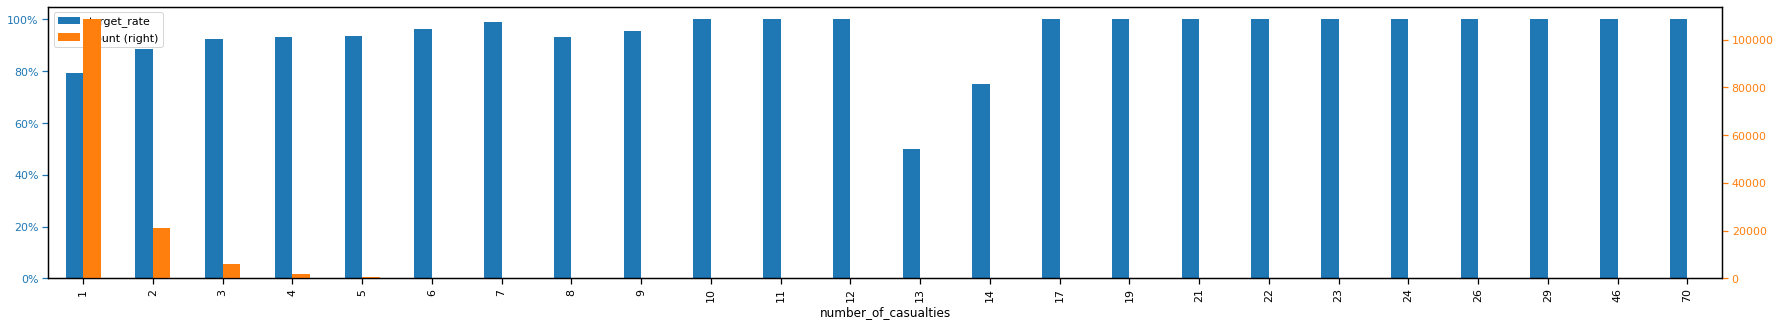

In [397]:
grouped = target_rate_and_plot('number_of_casualties')

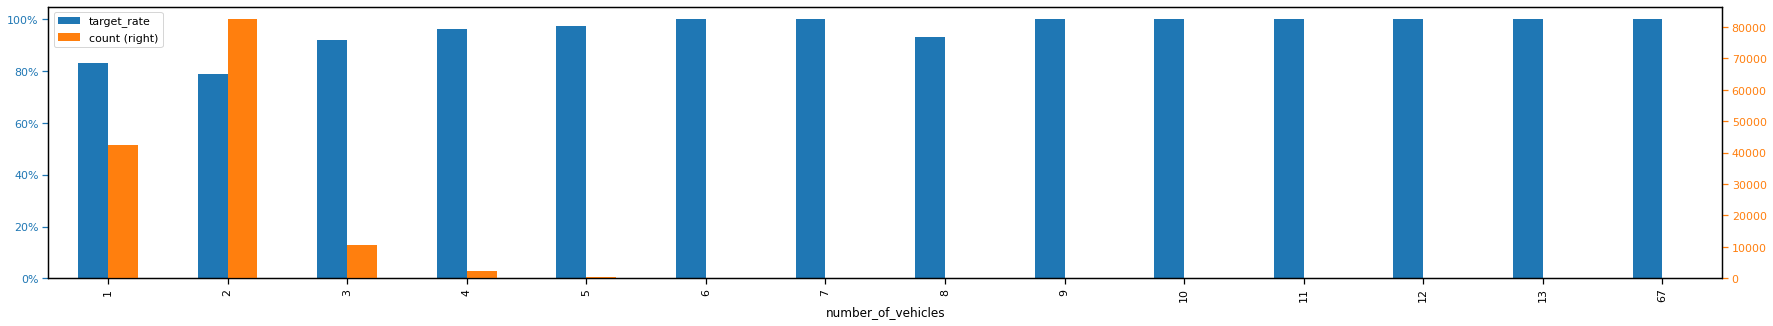

In [398]:
grouped = target_rate_and_plot('number_of_vehicles')

From the analysis of numeric variables, having more than 2 casualties or 2 vehicles results in higher target rate. Police are more likely to attend when the severity is higher. The trade off is the volumes are low after 2 both variables, potentially it could be more effective to say more than 1 casualty/vehicle is the new variable.
These new variables are created at the top of the notebook 


## Analyse low cardinality variables
We will then bin together categories with high and low target rates, so we have few features in our model

Analysis:  
The higher the speed limit, the more likely a police officer will attend  
Some police forces are more likely to attend accidents such as south wales and tayside. the met police is the most common police force  
The more severe an accident the more likely a police officer will attend  
Police Officers have a higher chance of attending a motorway/dual carriageway  
The junction control variable has a lot of missing data  
No lighting has a higher target rate  
Police officers are more likely to attend in wet/damp conditions vs dry  
Police officers are more likely to attend in a rural area  

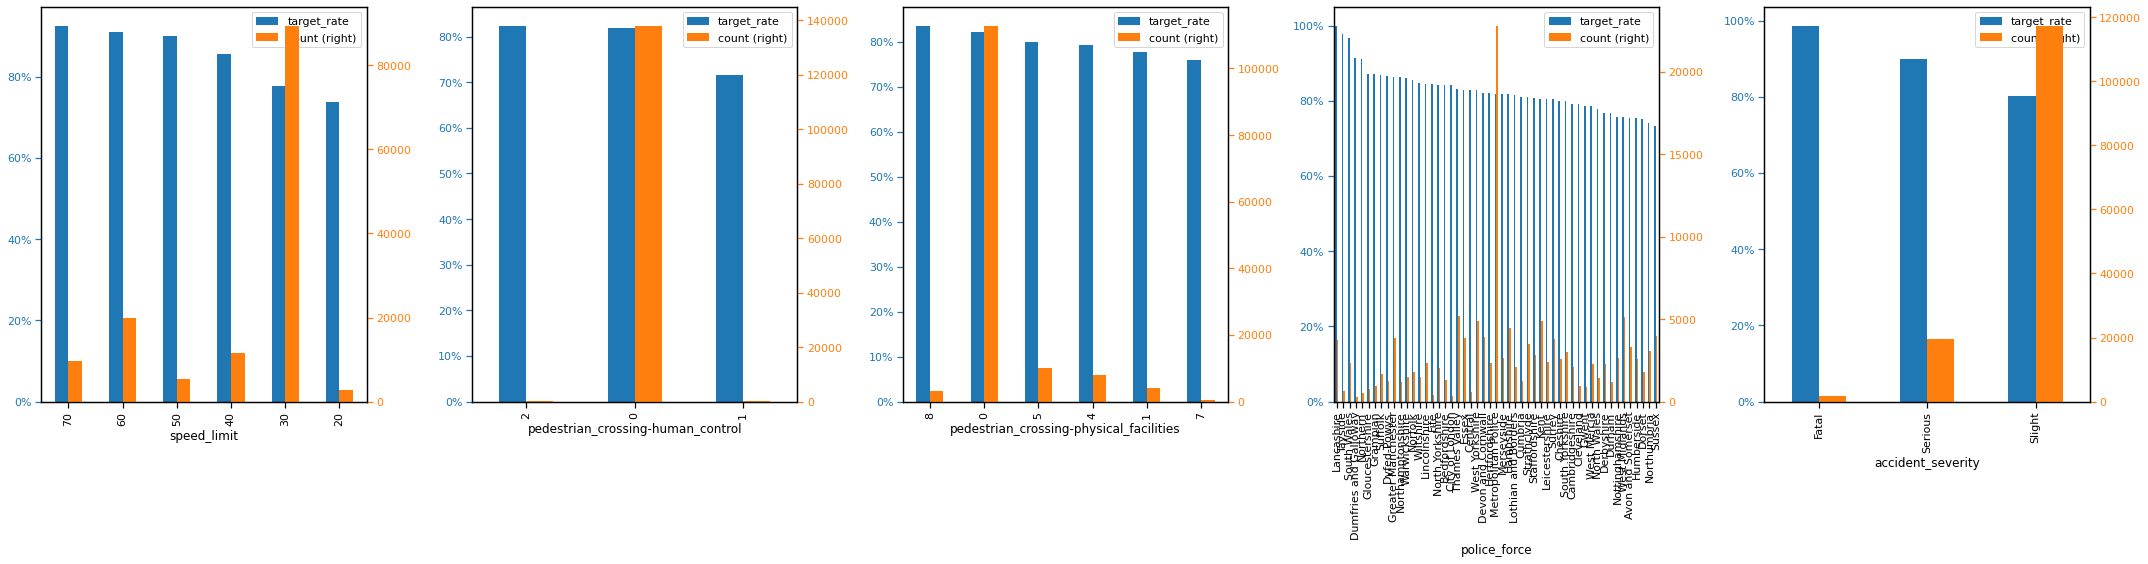

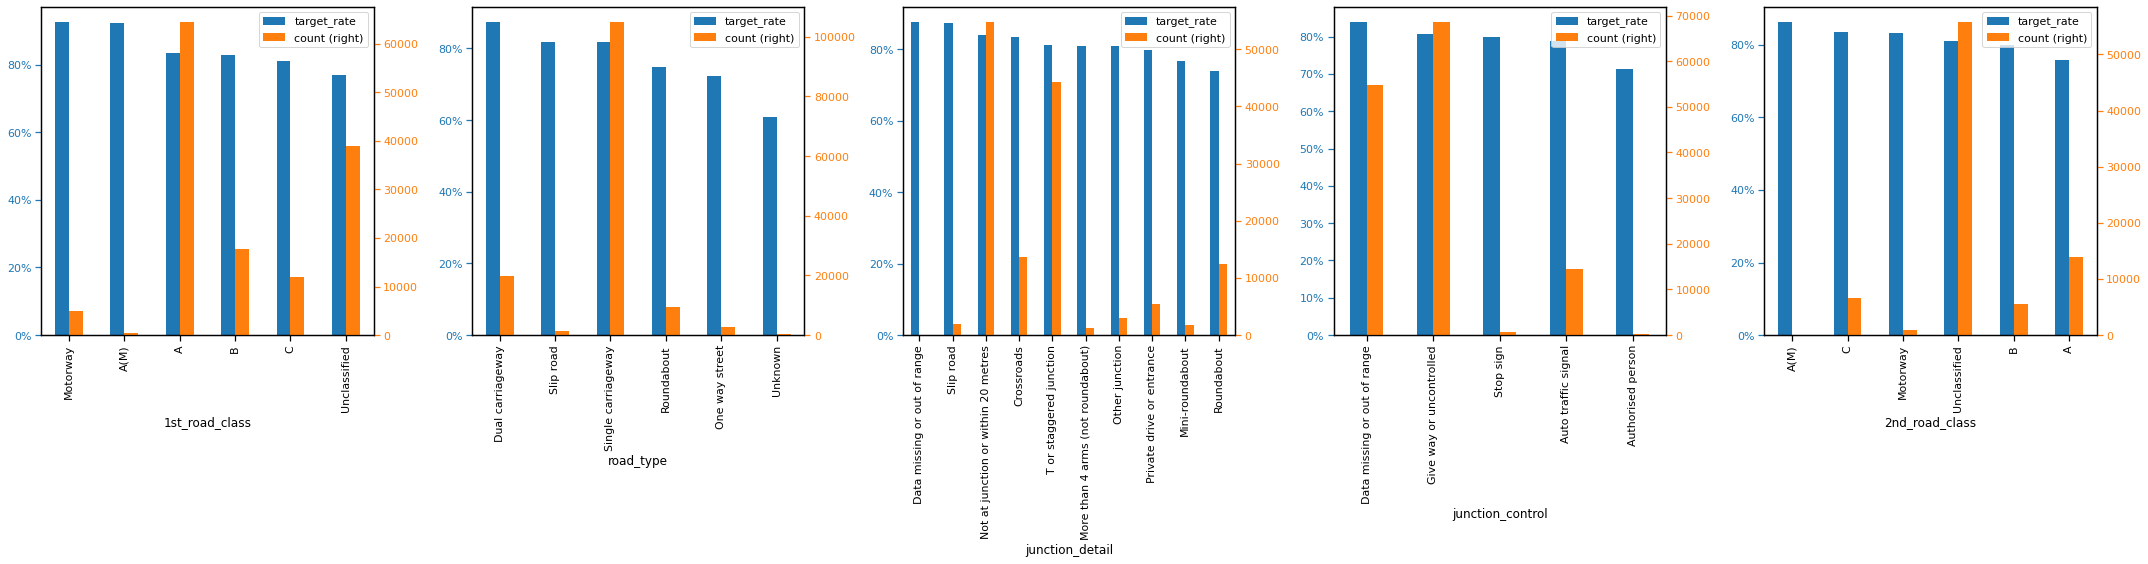

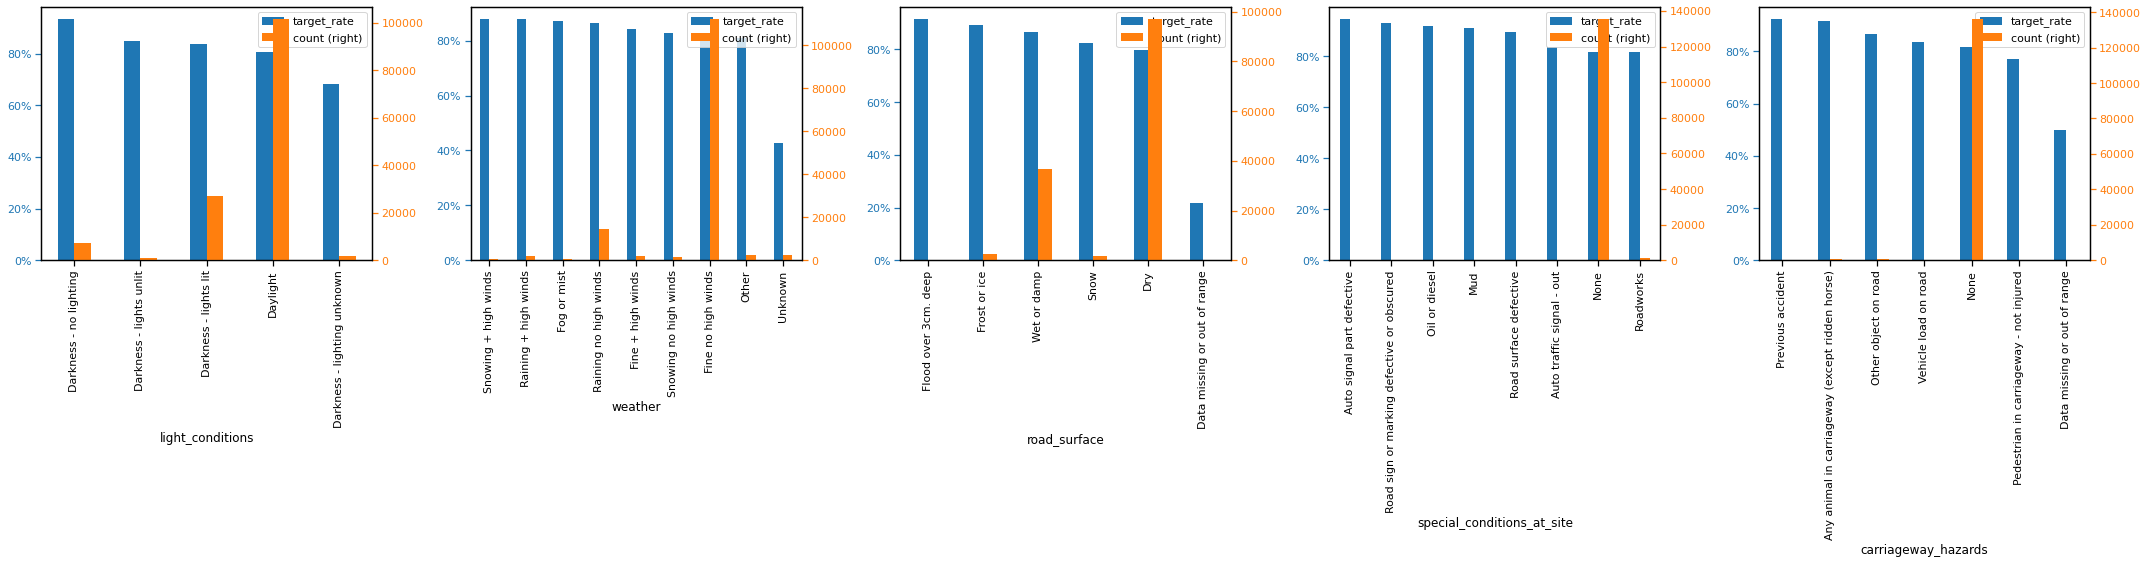

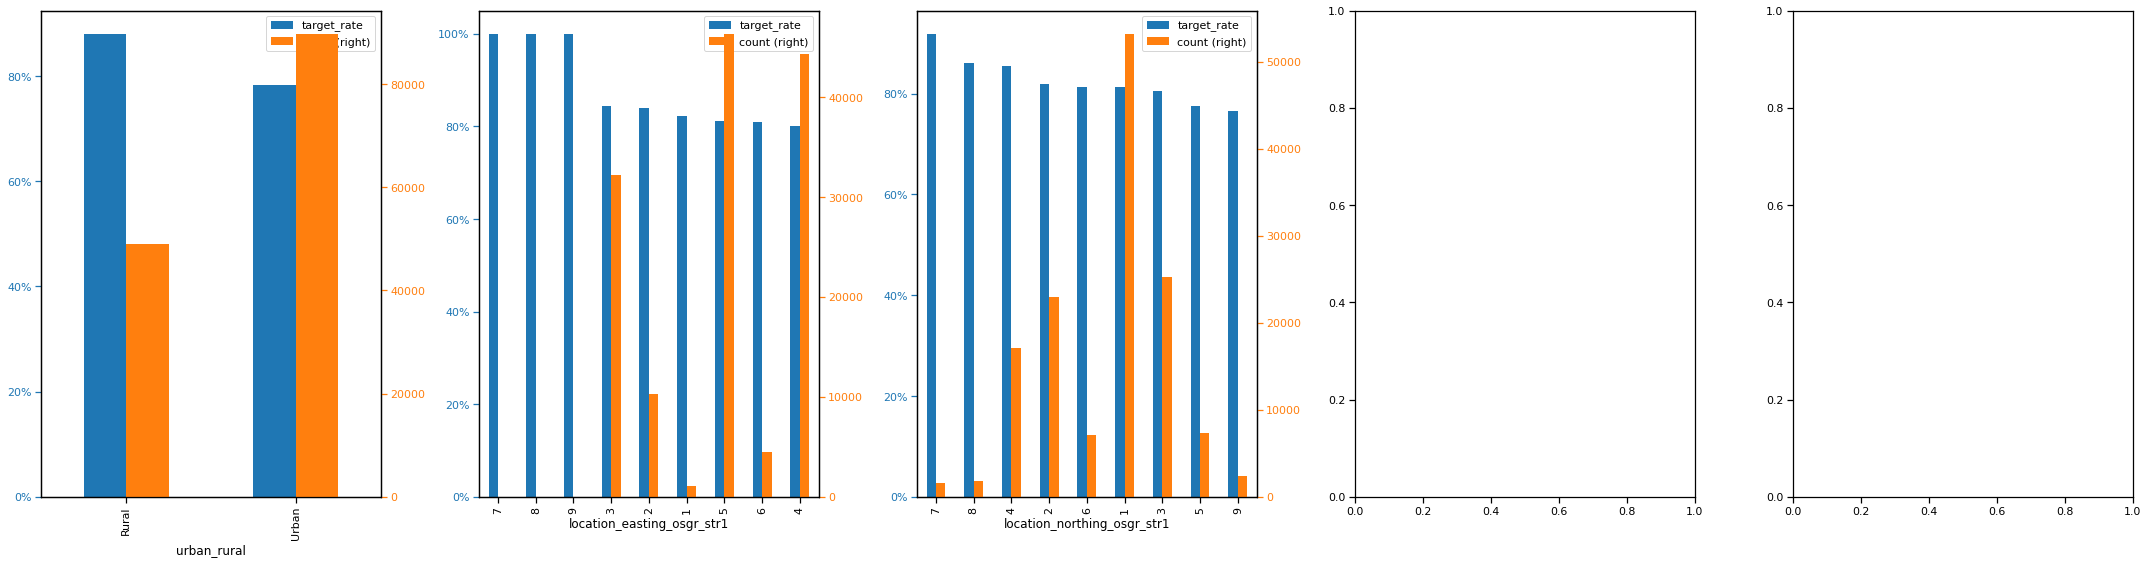

In [400]:
sns.set_context('notebook')

grouped_combined = pd.DataFrame()

cardinality = df.nunique()
low_cardinality = cardinality[cardinality<100]

low_cardinality = low_cardinality[low_cardinality.index != 'target']
low_cardinality = [i for i in low_cardinality.index if i not in numeric_variables +time_variables]
for i in range(int(np.ceil(len(low_cardinality)/5))):
    fig,ax = plt.subplots(1,5,figsize=(30,8))
    for col, ax_n in zip(low_cardinality[i*5:(i+1)*5],ax.flatten()):
        grouped = get_target_rate_and_count(df,col)
        plot_target_rate_and_count(grouped,ax_n)
        grouped['label'] = col
        grouped_combined = grouped_combined.append(grouped)
    plt.tight_layout()


    

Some police forces are more likely to attend accidents such as south wales and tayside. the met police is the most common police force  

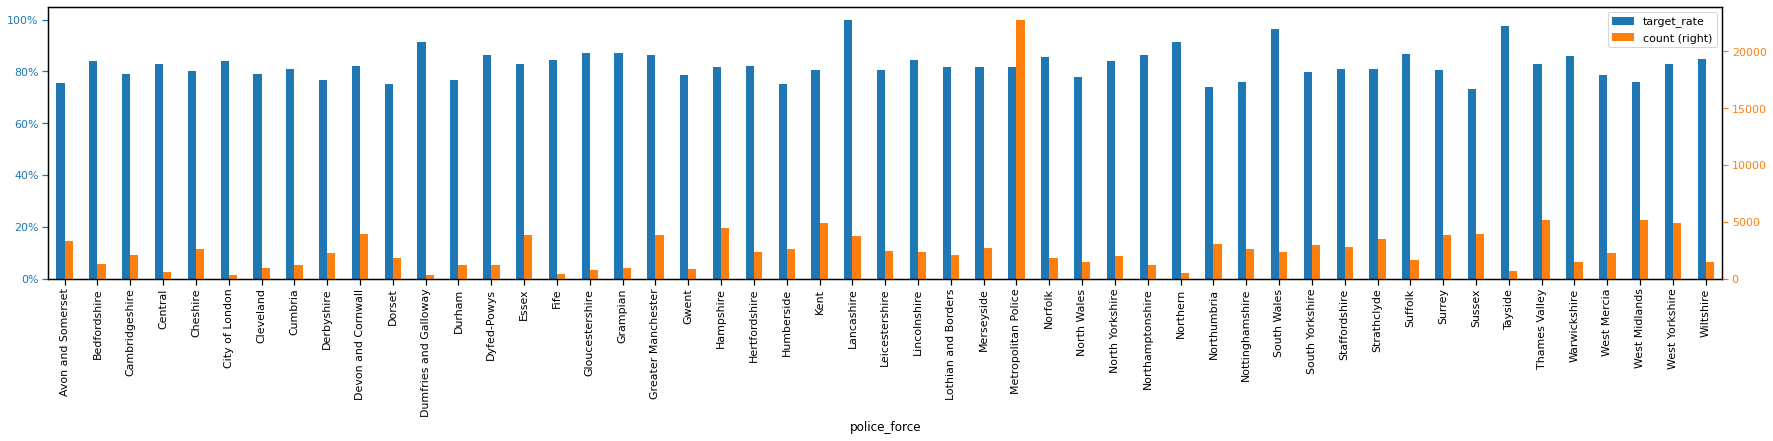

In [401]:
# analyse police forece in its own graph
grouped = target_rate_and_plot('police_force')

Most categorical variables have 70-95% target rate, and most have less than 5% share of the data

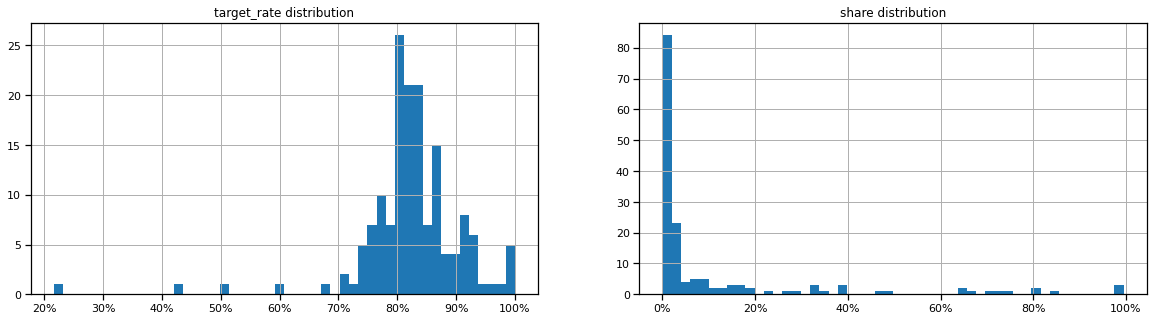

In [402]:
fig,ax = plt.subplots(1,2,figsize =(20,5))

for col,ax_n in zip(['target_rate','share'],ax.flatten()):
    grouped_combined[col].hist(bins=50,ax = ax_n)
    ax_n.xaxis.set_major_formatter(PercentFormatter(1))
    ax_n.set_title(col+' distribution')

### Find categories with high and low target rates
We will count categories with target rate over 85% in the high bin group, and under 75 in the low bin group

In [403]:
grouped_combined.query('target_rate>0.85').sort_values('count',ascending=False).T

,Rural,Wet or damp,60,Dual carriageway,Serious,4,Raining no high winds,40,70,Darkness - no lighting,50,Motorway,Greater Manchester,Lancashire,Frost or ice,South Wales,Raining + high winds,Slip road,Norfolk,8,Suffolk,Fatal,7,Warwickshire,Dyfed-Powys,Northamptonshire,Other object on road,Grampian,Gloucestershire,Any animal in carriageway (except ridden horse),Tayside,Fog or mist,Snowing + high winds,Northern,Mud,Oil or diesel,A(M),Road surface defective,Dumfries and Galloway,Previous accident,Flood over 3cm. deep,Road sign or marking defective or obscured,A(M),Auto signal part defective,Data missing or out of range,9,8,7
target_rate,0.880146,0.86681,0.910555,0.872918,0.899918,0.855561,0.864373,0.856571,0.925544,0.935161,0.899813,0.925748,0.863248,1,0.890511,0.965885,0.877551,0.873732,0.85473,0.861425,0.868026,0.98694,0.918766,0.860041,0.86515,0.862469,0.864198,0.870075,0.872258,0.914169,0.976599,0.870759,0.87931,0.912109,0.909091,0.918269,0.922705,0.89418,0.912458,0.924171,0.915789,0.928994,0.862069,0.946429,0.875,1,1,1
count,48926,36737,19990,19751,19624,17066,14562,11490,9697,7295,5340,4983,3861,3755,2466,2345,2156,1972,1776,1768,1667,1608,1588,1479,1231,1207,972,939,775,734,641,619,522,512,440,416,414,378,297,211,190,169,87,56,8,3,2,1
share,0.352849,0.264943,0.144166,0.142442,0.141526,0.123078,0.105019,0.0828646,0.0699337,0.0526107,0.0385115,0.0359368,0.0278451,0.0270806,0.0177845,0.0169119,0.0155488,0.0142218,0.0128083,0.0127506,0.0120222,0.0115967,0.0114525,0.0106664,0.00887783,0.00870475,0.00700995,0.00677196,0.00558921,0.00529352,0.00462282,0.00446416,0.0037646,0.00369249,0.00317323,0.00300014,0.00298572,0.00272609,0.00214193,0.00152171,0.00137026,0.00121881,0.00105103,0.000403866,5.76951e-05,2.16357e-05,1.44238e-05,7.21189e-06
label,urban_rural,road_surface,speed_limit,road_type,accident_severity,location_northing_osgr_str1,weather,speed_limit,speed_limit,light_conditions,speed_limit,1st_road_class,police_force,police_force,road_surface,police_force,weather,junction_detail,police_force,location_northing_osgr_str1,police_force,accident_severity,location_northing_osgr_str1,police_force,police_force,police_force,carriageway_hazards,police_force,police_force,carriageway_hazards,police_force,weather,weather,police_force,special_conditions_at_site,special_conditions_at_site,1st_road_class,special_conditions_at_site,police_force,carriageway_hazards,road_surface,special_conditions_at_site,2nd_road_class,special_conditions_at_site,junction_detail,location_easting_osgr_str1,location_easting_osgr_str1,location_easting_osgr_str1


In [404]:
grouped_combined.query('target_rate<0.75').sort_values('count',ascending=False).T

,Roundabout,Roundabout,Sussex,Northumbria,One way street,20,Unknown,Darkness - lighting unknown,Unknown,1,Data missing or out of range,Authorised person,Data missing or out of range
target_rate,0.738966,0.748857,0.733789,0.74165,0.723032,0.738363,0.427533,0.682044,0.607724,0.715543,0.216216,0.713514,0.5
count,12439,9405,3948,3054,2744,2664,2477,2016,492,341,259,185,2
share,0.0897086,0.0678278,0.0284725,0.0220251,0.0197894,0.0192125,0.0178638,0.0145392,0.00354825,0.00245925,0.00186788,0.0013342,1.44238e-05
label,junction_detail,road_type,police_force,police_force,road_type,speed_limit,weather,light_conditions,road_type,pedestrian_crossing-human_control,road_surface,junction_control,carriageway_hazards


## Bin categorical variables
We exclude the time based and numeric variables as those have already been binned

In [405]:
features_to_bin = low_cardinality.copy()

In [406]:
def generate_binning_dict(rate_type, rate):
    binning_dict = {}
    for i in features_to_bin:
        
        if rate_type == 'high':
            data_sub = grouped_combined.query('(label==@i)&(target_rate>@rate)')
        else:
            data_sub = grouped_combined.query('(label==@i)&(target_rate<@rate)')
        if(data_sub['share'].sum()>0.03):
            binning_dict[i] = list(data_sub.index)
    
    return binning_dict

In [407]:
high_rate_dict = generate_binning_dict('high', 0.85)

In [408]:
low_rate_dict = generate_binning_dict('low', 0.75)

These dictionaries define what categories in each variable will be grouped into high or low bins

In [409]:
high_rate_dict

{'speed_limit': [70, 60, 50, 40],
 'police_force': ['Lancashire',
  'Tayside',
  'South Wales',
  'Dumfries and Galloway',
  'Northern',
  'Gloucestershire',
  'Grampian',
  'Suffolk',
  'Dyfed-Powys',
  'Greater Manchester',
  'Northamptonshire',
  'Warwickshire',
  'Norfolk'],
 'accident_severity': ['Fatal', 'Serious'],
 '1st_road_class': ['Motorway', 'A(M)'],
 'road_type': ['Dual carriageway'],
 'light_conditions': ['Darkness - no lighting'],
 'weather': ['Snowing + high winds',
  'Raining + high winds',
  'Fog or mist',
  'Raining no high winds'],
 'road_surface': ['Flood over 3cm. deep', 'Frost or ice', 'Wet or damp'],
 'urban_rural': ['Rural'],
 'location_northing_osgr_str1': ['7', '8', '4']}

In [410]:
low_rate_dict

{'police_force': ['Northumbria', 'Sussex'],
 'road_type': ['Roundabout', 'One way street', 'Unknown'],
 'junction_detail': ['Roundabout']}

Save the dictionaries so they can be used in the data preparation for the test set

In [411]:
dp.save_obj(high_rate_dict,'high_rate_dict')
dp.save_obj(low_rate_dict,'low_rate_dict')

## Generate new binned features based on the high and low_rate dictionaries
Now we will use the dictionaries to create the new columns

In [412]:
def generate_binned_features(data,rate_dict,rate_type='high'):
    '''
    This function creates new features in data based on the dictionary rate_dict. If the column for the key in rate dict contains variables in the value (list) for the key then it will be classed as 1 in the new column
    the new column will be called the same as the key but have a suffix of _high or _low based on rate type (whether the list means they have high or low rates of the target)
    
    Parameters:
    data: pandas.DataFrame to manipulate
    rate_dict: dict. features, with values that are the list of values that will be binned to one group
    rate_type: whether the values in the key have a high or low target rate. this will be the suffix for the new column
    '''
    
    
    new_cols = []
    for col, values in rate_dict.items():
        new_col = col+'_'+rate_type
        data[new_col] = np.where(data[col].isin(values),1,0)
        new_cols.append(new_col)
    return new_cols

In [413]:
binned_high_cols = generate_binned_features(df,high_rate_dict,rate_type='high')
binned_low_cols = generate_binned_features(df,low_rate_dict,rate_type='low')

In [414]:
binned_variables = binned_high_cols +binned_low_cols

## Analyse time data
We want to analyse the time series of the data:  
When do police officers attending accidents/accidents occur?   
are they more frequent on certain days?  
are they more frequent on certain months?  
are they more frequent on certain hours?
are they more frequent on certain minutes past the hour?

## Time Series
The target occurs with no observable pattern throughout the year


<AxesSubplot:xlabel='date'>

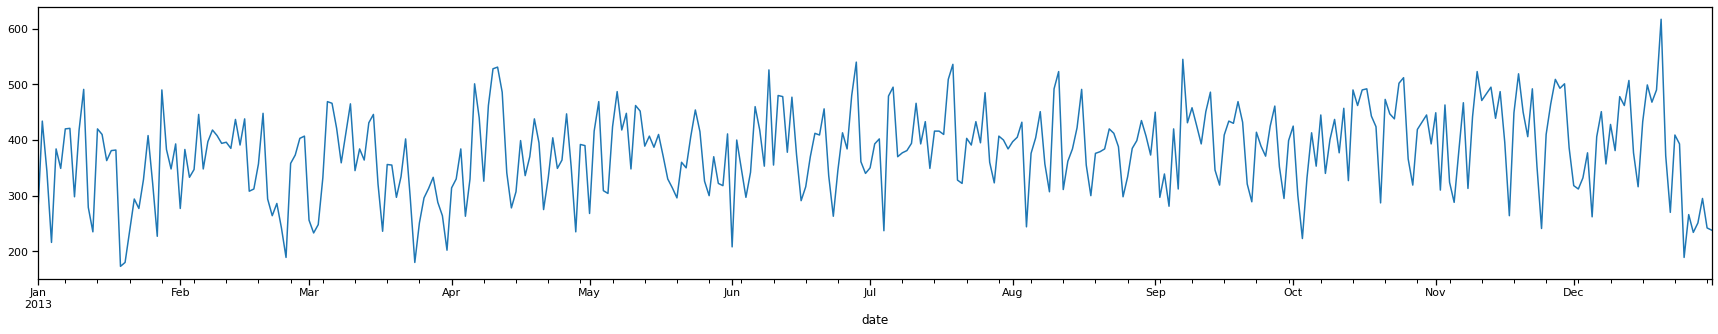

In [415]:
df.groupby('date').count()['target'].plot(figsize=(30,5))

## Time of day
There are spikes in the target at intervals throughout the day (the next cells shows it's at every half hour period)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='time'>

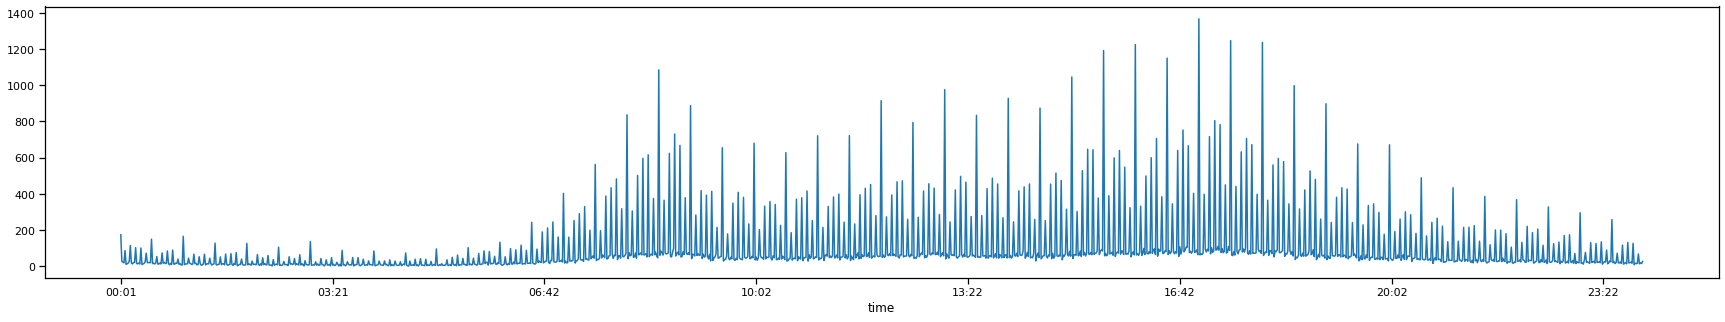

In [416]:
df.groupby('time').count()['target'].plot(figsize=(30,5))

# By hour
Accidents occur more often in morning and evening rush hour. Target rate is higher before 6am and after 10pm, perhaps due to more availability of police

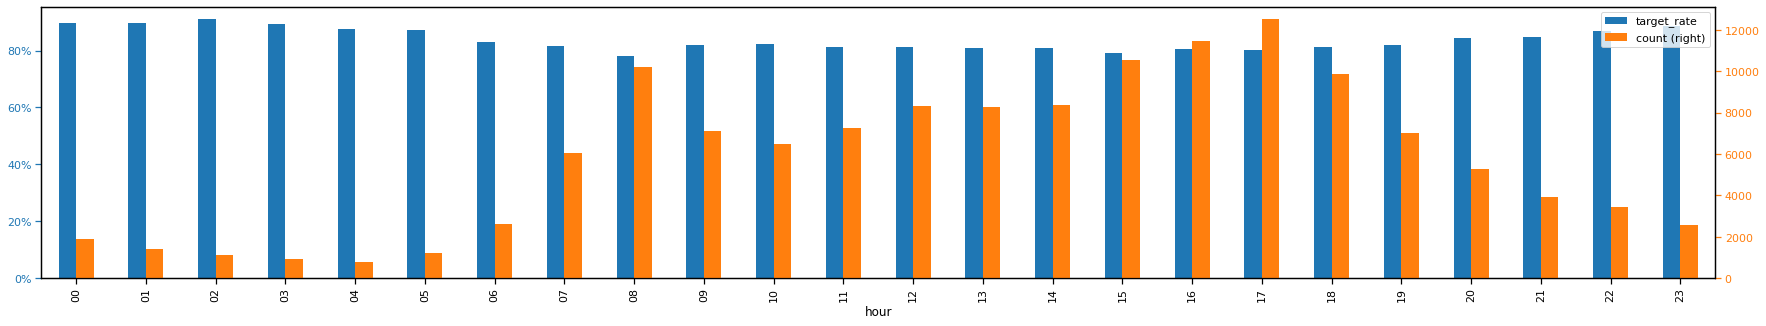

In [417]:
time_var = 'hour'
grouped = get_target_rate_and_count(df,time_var)

fig,ax = plt.subplots(1,1,figsize=(30,5))
plot_target_rate_and_count(grouped.sort_values(time_var),ax)

## by Minute
The target rate is lowest at 15 min intervals past the hour. Perhaps when police do not attend, a different party is reporting the accident rounding to 15min times (?)


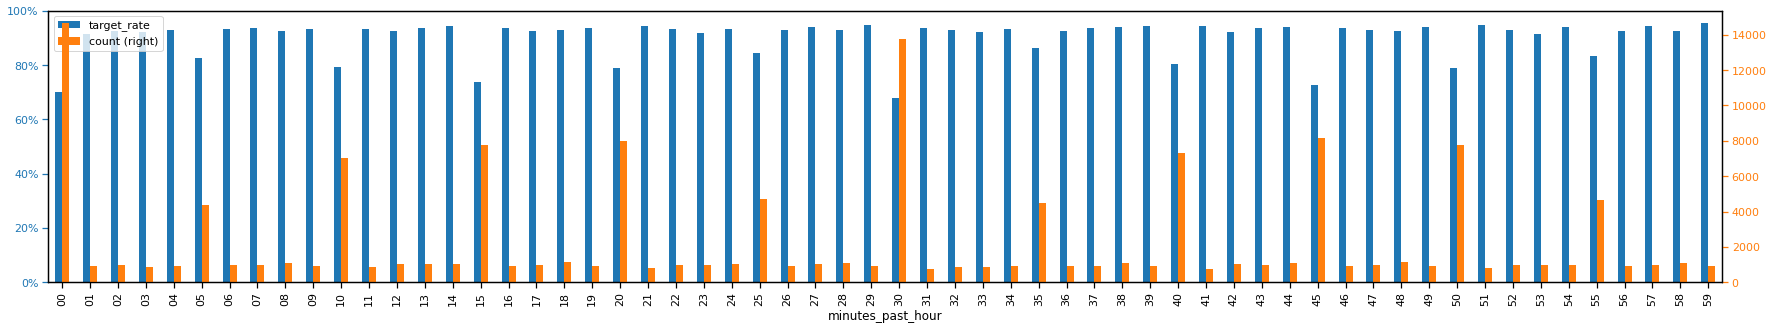

In [418]:
time_var = 'minutes_past_hour'
grouped = get_target_rate_and_count(df,time_var)

fig,ax = plt.subplots(1,1,figsize=(30,5))
plot_target_rate_and_count(grouped.sort_values(time_var),ax)

# By Month
There is no obvious difference in target rate by month

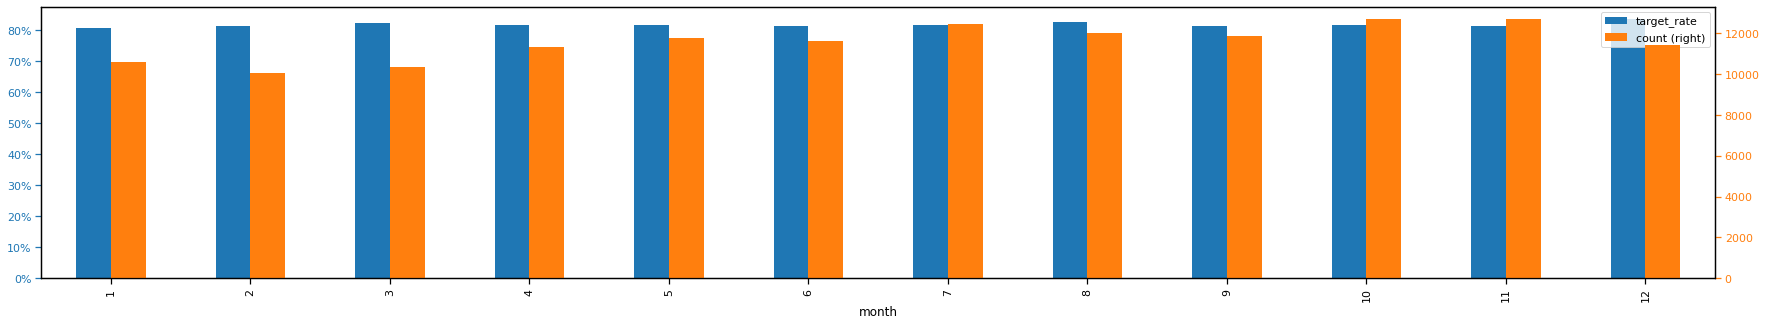

In [419]:
time_var = 'month'
grouped = get_target_rate_and_count(df,time_var)

fig,ax = plt.subplots(1,1,figsize=(30,5))
plot_target_rate_and_count(grouped.sort_values(time_var),ax)

# By Day of week
Target rate is higher on weekends

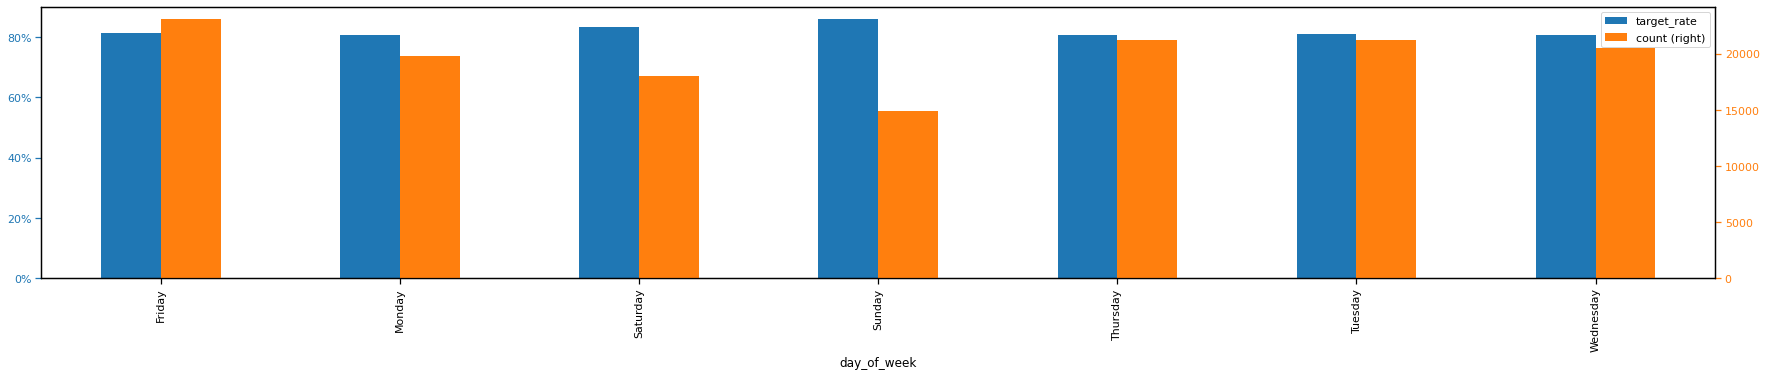

In [420]:
time_var = 'day_of_week'
grouped = get_target_rate_and_count(df,time_var)

fig,ax = plt.subplots(1,1,figsize=(30,5))
plot_target_rate_and_count(grouped.sort_values(time_var),ax)

## Mapping accidents to a UK region
We will see if we can isolate regions with a high target rate
We will use the UKs NUTS3 mapping as these have small regions, which might isolate high rate areas  
We will use the geopandas package to join a GeoJSON to the data and visualise it

In [421]:
# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point

In [422]:
def join_geojson(data,geojson_path):
    '''
    This function reads in the geojson from the geojson_path, creates a geometry column from the longitude and latitude columns of data and joins data to the geojson, where each row is situated inside the polygon (region) of a row in the geo_json
    
    Parameters:
    data: dataframe with columns for longitude and latitude
    geojson_path: path to geojson file
    
    Returns:
    geo_json: GeoDataFrame. What was read from the path
    data_geo: data with join to geojson, i.e. points mapped to a region in geojson
    
    '''
    # geo_json = gpd.read_file('https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/eurostat/ew/nuts2.json')
    geo_json = gpd.read_file(geojson_path)
    
    data = data.copy()
    # create a point geometry column using Point from the shapely package
    data['geometry'] = data.apply(
    lambda x: Point((x.longitude, x.latitude)),
    axis = 1)

    # set the crs - degrees
    data_crs = {'init': 'epsg:4326'}
    data_geo = gpd.GeoDataFrame(data,
    crs = data_crs,
    geometry = data.geometry)
    # convert the crs to match the geo_json (for some reason it doesn't work when one initially makes the geojson)
    data_geo = data_geo.to_crs(geo_json.crs)
    
    data_geo = gpd.sjoin(geo_json,data_geo,op='contains')
    
    return geo_json, data_geo

def plot_geojson(geo_json_with_target,col='target_rate'):    
    '''
    This function plots your geojson with a column used to shade each region. Geo_json must have one row per region, and a numeric column, col, to shade with
    Col is defaulted the target_rate. This is so you can measure target rate across regions
    
    Parameters:
    geo_json_with_target: geoDataFrame with numeric column for plotting shade
    col: str. columns to shade regions using   
    
    '''
    geo_json_with_target.plot(column=col, legend=True, cmap = 'BuGn',edgecolor='Black',figsize=(10,10))    

## Join GeoJSON to the data
We will read in our GeoJSON and join to df to make a new geopandas dataframe

In [423]:
# geo_json, geo_data = join_geojson(df,geojson_path='http://geoportal1-ons.opendata.arcgis.com/datasets/473aefdcee19418da7e5dbfdeacf7b90_0.geojson?outSR={%22latestWkid%22:27700,%22wkid%22:27700}')
geo_json, geo_data = join_geojson(df,geojson_path='https://datahub.io/core/geo-nuts-administrative-boundaries/r/nuts_rg_60m_2013_lvl_3.geojson')




/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [424]:
geo_json.head()

,NUTS_ID,STAT_LEVL_,SHAPE_AREA,SHAPE_LEN,geometry
0,AT111,3,0.080896,1.088912,"POLYGON ((16.64622 47.44660, 16.43376 47.35292..."
1,AT112,3,0.252917,2.229645,"POLYGON ((17.16080 48.00666, 17.09307 47.70824..."
2,AT113,3,0.197644,1.952596,"POLYGON ((16.43376 47.35292, 16.50827 47.00126..."
3,AT121,3,0.430926,2.989854,"POLYGON ((15.50768 48.31960, 15.42240 48.21082..."
4,AT122,3,0.425235,2.961301,"POLYGON ((16.38889 47.88160, 16.26905 47.79641..."


We will find out if particular regions have high target rate

In [425]:
# get target rate by region
# grouped_by_region = get_target_rate_and_count(geo_data,'nuts318cd')
grouped_by_region = get_target_rate_and_count(geo_data,'NUTS_ID')


In [426]:
grouped_by_region.head()

,target_rate,count,share
NUTS_ID,,,
UKM66,1.0,14,0.000107
UKD41,1.0,422,0.003217
UKM64,1.0,15,0.000114
UKD46,1.0,719,0.005481
UKD45,1.0,937,0.007143


Most regions are between 75-90% target rate, and have share of total below 1%

array([[<AxesSubplot:title={'center':'target_rate'}>,
        <AxesSubplot:title={'center':'count'}>],
       [<AxesSubplot:title={'center':'share'}>, <AxesSubplot:>]],
      dtype=object)

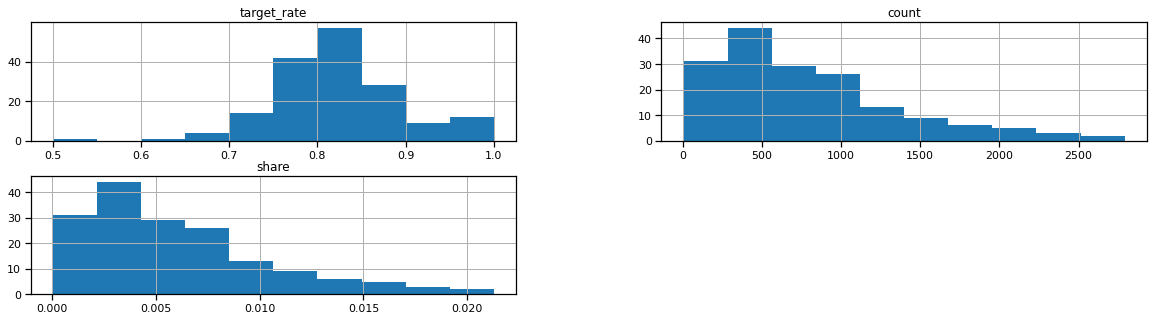

In [427]:
# analyse the target rates by region. on average it is 15-20%
grouped_by_region.hist(figsize=(20,5))

In [429]:
# Join the target rates to the original geojson so we can plot a map
geo_json_with_target = geo_json.merge(grouped_by_region.reset_index())

In [430]:
geo_json_with_target.head()

,NUTS_ID,STAT_LEVL_,SHAPE_AREA,SHAPE_LEN,geometry,target_rate,count,share
0,UKC11,3,0.029501,0.761684,"POLYGON ((-1.26125 54.57190, -1.23479 54.51037...",0.785340,382,0.002912
1,UKC12,3,0.014307,0.984086,"POLYGON ((-0.79091 54.55948, -1.23479 54.51037...",0.780374,214,0.001631
2,UKC13,3,0.014018,0.639463,"POLYGON ((-1.43478 54.48751, -1.69687 54.53606...",0.696809,188,0.001433
3,UKC14,3,0.319088,2.494130,"POLYGON ((-1.55934 54.88210, -1.34737 54.86069...",0.790485,1093,0.008332
4,UKM31,3,0.086590,1.780714,"POLYGON ((-4.59821 56.08434, -4.47081 56.00240...",0.803448,290,0.002211


Darker regions are where the target rate is higher. There is a cluster near Liverpool and in south wales. Scotland seems to have darker regions (might be impacte by lower volumes)

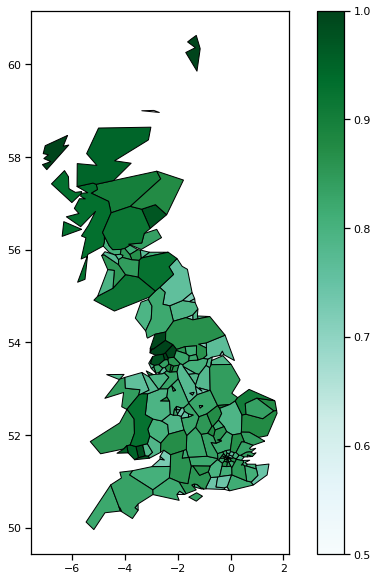

In [431]:
plot_geojson(geo_json_with_target,col='target_rate')

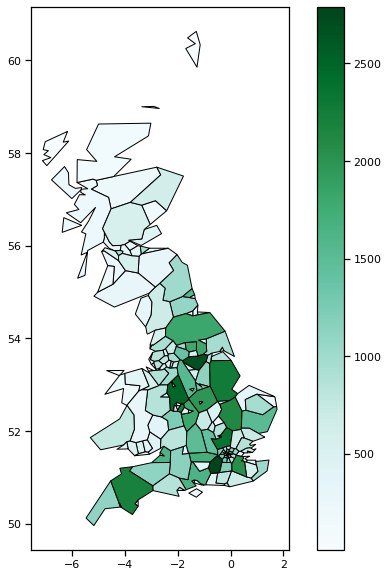

In [451]:
plot_geojson(geo_json_with_target,col='count')

We will try to bin areas with high or low target rate

In [432]:
grouped_by_region.query('target_rate<0.75').sum()

target_rate       14.101290
count          15013.000000
share              0.114441
dtype: float64

In [433]:
grouped_by_region.query('target_rate>0.9').sum()

target_rate      20.172694
count          7834.000000
share             0.059717
dtype: float64

In [434]:
high_rate_dict_location = {'NUTS_ID':grouped_by_region.query('target_rate>0.9').index}
low_rate_dict_location = {'NUTS_ID':grouped_by_region.query('target_rate<0.75').index}


In [435]:
## These are the regions with high and low target rate, we will hardcode them when binning into binary columns
print('high rate vars')
display(high_rate_dict_location)
print('low rate vars')
display(low_rate_dict_location)

high rate vars


{'NUTS_ID': Index(['UKM66', 'UKD41', 'UKM64', 'UKD46', 'UKD45', 'UKD42', 'UKD44', 'UKL15',
        'UKD47', 'UKM21', 'UKL22', 'UKL18', 'UKM61', 'UKL17', 'UKM63', 'UKM24',
        'UKL24', 'UKM27', 'UKM32', 'UKH11', 'UKH16'],
       dtype='object', name='NUTS_ID')}

low rate vars


{'NUTS_ID': Index(['UKJ44', 'UKI41', 'UKJ28', 'UKG33', 'UKJ27', 'UKF16', 'UKG31', 'UKF11',
        'UKC23', 'UKE21', 'UKK12', 'UKF21', 'UKC22', 'UKK11', 'UKC13', 'UKK21',
        'UKE11', 'UKF14', 'UKJ21', 'UKM65'],
       dtype='object', name='NUTS_ID')}

### Create new location variables with high/low target rates

Merge the original dataframe to the geodata region mapping

In [436]:
df = df.merge(geo_data[['accident_index','NUTS_ID']],how='left')

Create binned variables with NUTS3 regions with a high target rate, and with low target rate

In [437]:
df['NUTS_ID_high'] = np.where(df['NUTS_ID'].isin(['UKM66', 'UKD41', 'UKM64', 'UKD46', 'UKD45', 'UKD42', 'UKD44', 'UKL15',
        'UKD47', 'UKM21', 'UKL22', 'UKL18', 'UKM61', 'UKL17', 'UKM63', 'UKM24',
        'UKL24', 'UKM27', 'UKM32', 'UKH11', 'UKH16']),1,0)
df['NUTS_ID_low'] = np.where(df['NUTS_ID'].isin(['UKJ44', 'UKI41', 'UKJ28', 'UKG33', 'UKJ27', 'UKF16', 'UKG31', 'UKF11',
        'UKC23', 'UKE21', 'UKK12', 'UKF21', 'UKC22', 'UKK11', 'UKC13', 'UKK21',
        'UKE11', 'UKF14', 'UKJ21', 'UKM65']),1,0)

In [438]:
nuts_variables = ['NUTS_ID_high','NUTS_ID_low']

## Determine the weight of evidence information value
Higher IV implies the feature will be have more information for the target

In [439]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        global d
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [440]:
newDF, woeDF = iv_woe(df, 'target', bins=10, show_woe=False)

Information value of accident_index is 2.948257
Information value of location_easting_osgr is 0.018583
Information value of location_northing_osgr is 0.020408
Information value of longitude is 0.018535
Information value of latitude is 0.020383
Information value of number_of_vehicles is 0.089471
Information value of number_of_casualties is 0.055246
Information value of date is 0.035803
Information value of time is 0.570039
Information value of 1st_road_number is 0.018589
Information value of speed_limit is 0.194283
Information value of 2nd_road_number is 0.011188
Information value of pedestrian_crossing-human_control is 0.000978
Information value of pedestrian_crossing-physical_facilities is 0.006278
Information value of lsoa_of_accident_location is 1.073507
Information value of police_force is 0.33951
Information value of accident_severity is 0.101199
Information value of day_of_week is 0.01299
Information value of local_authority_(district) is 0.341568
Information value of local_autho

As expected, time and speed limit have a high information value

## Remove correlated variables
Removing correlated variables will mean fewer features for our model, which reduces training time and creates fewer dependencies if a model goes into production

First we will extract our engineered features we want to use

In [441]:
used_features = used_time_variables+used_numeric_variables+binned_variables + nuts_variables

Generate a correlation heat map. speed limit high and urban or rural area high are correlated (higher speeds in rural areas), one can be removed
Road surface also correlates with weather (which makes sense as rain implies wet roads)

In [442]:
def corr_heatmap(data):
    plt.figure(figsize=(20,20))
    sns.heatmap(np.round(data.corr(),2),annot=True,cmap='viridis')

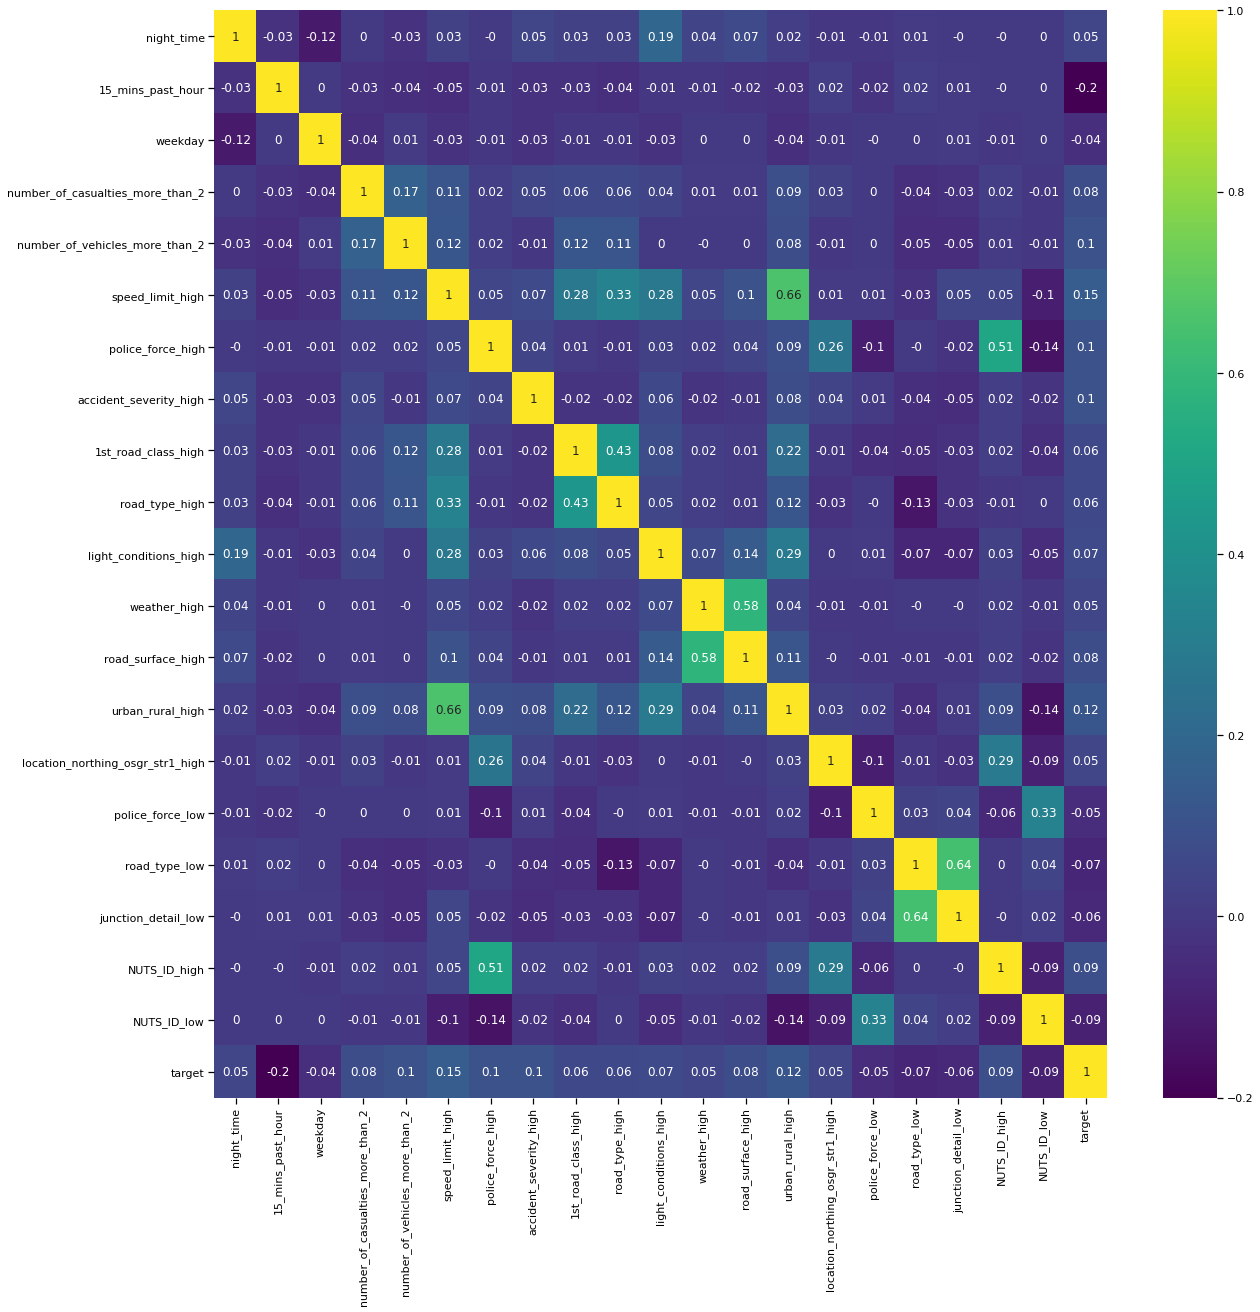

In [443]:
corr_heatmap(df[used_features+['target']])

## Remove correlated variables

In [444]:
# we will use a function to remove correlated variables
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of columns to be deleted
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (np.abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                

    return col_corr

In [445]:
features_to_remove = correlation(df[used_features], 0.5)
features_to_remove

{'NUTS_ID_high',
 'junction_detail_low',
 'road_surface_high',
 'urban_rural_high'}

In [446]:
used_features_2 = [i for i in used_features if i not in features_to_remove]

Visualise new variables

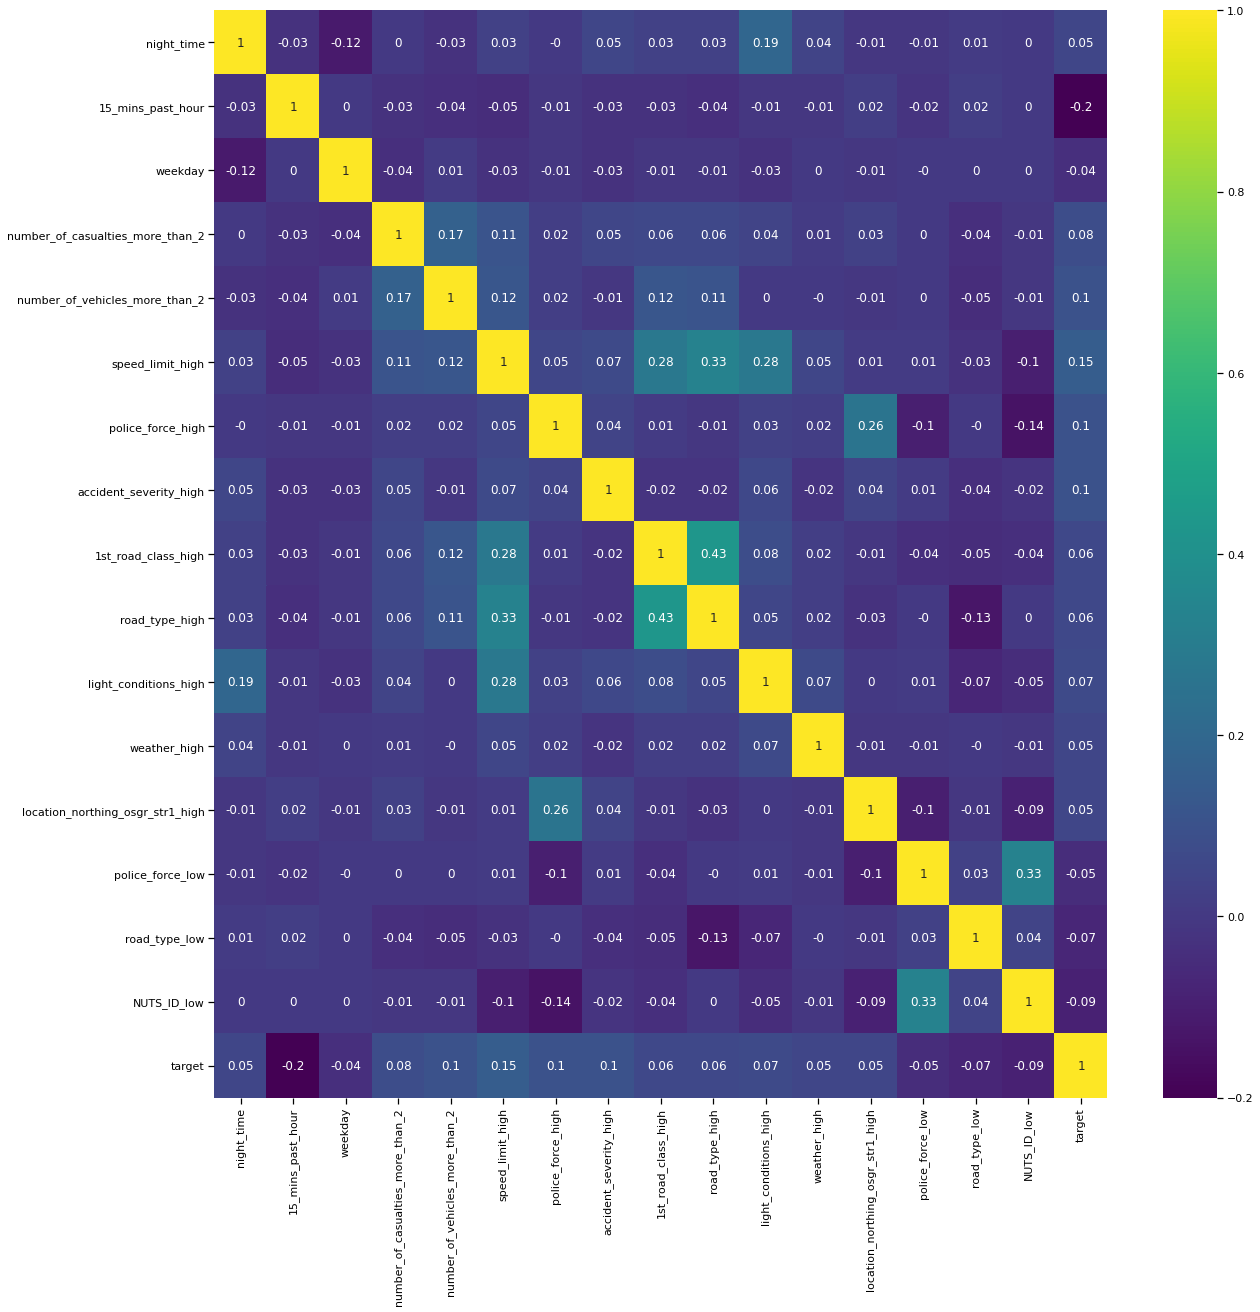

In [447]:
corr_heatmap(df[used_features_2+['target']])

15 mins past hour, speed limit high and accident_severity_high are the best correlated variables with the target

## Save features into a dictionary
We can use the new cleaned features for modelling
Because the map shows clusters of police attending accidents this may mean a KNN might work well using longitude and latitude so I will save these as featurse for KNN

In [448]:
feature_dict = {'cleaned':used_features_2,'knn':['longitude','latitude','15_mins_past_hour','speed_limit_high','number_of_casualties_more_than_2']}

In [449]:
dp.save_obj(feature_dict,'feature_dict')

In [450]:
dp.load_obj('feature_dict')

{'cleaned': ['night_time',
  '15_mins_past_hour',
  'weekday',
  'number_of_casualties_more_than_2',
  'number_of_vehicles_more_than_2',
  'speed_limit_high',
  'police_force_high',
  'accident_severity_high',
  '1st_road_class_high',
  'road_type_high',
  'light_conditions_high',
  'weather_high',
  'location_northing_osgr_str1_high',
  'police_force_low',
  'road_type_low',
  'NUTS_ID_low'],
 'knn': ['longitude',
  'latitude',
  '15_mins_past_hour',
  'speed_limit_high',
  'number_of_casualties_more_than_2']}